In [411]:
import matplotlib.pyplot as plt
import random
import time
import math

In [412]:
NUM_CENTROIDS = 3
CENTROIDS = []
COORD_RANGE = (-10, 10)
NUM_POINTS_PER_CLUSTER = 300
POINTS = []
SPREAD = 5
COLORS = ['green', 'purple', 'orange']

In [413]:
for _ in range(NUM_CENTROIDS):
    CENTROIDS.append([random.uniform(*COORD_RANGE), random.uniform(*COORD_RANGE)])

In [414]:
CENTROIDS

[[-3.2197164292914904, -0.583842403875046],
 [-1.6079953025105365, 4.021635575678292],
 [-5.858597666489313, -2.54919229389807]]

In [415]:
# generate 300 points per centroid
# with a probability of more likely to be closed to their centroid
# Normal Distribution => data points will be distributed near mean

# random.gauss(mu, sigma)
# mu -> mean or center of the dist
# sigma -> standard deviation or spread
for cx, cy in CENTROIDS:
    for _ in range(NUM_POINTS_PER_CLUSTER):
        x = random.gauss(cx, SPREAD)
        y = random.gauss(cy, SPREAD)
        POINTS.append((x ,y))

In [416]:
len(POINTS)

900

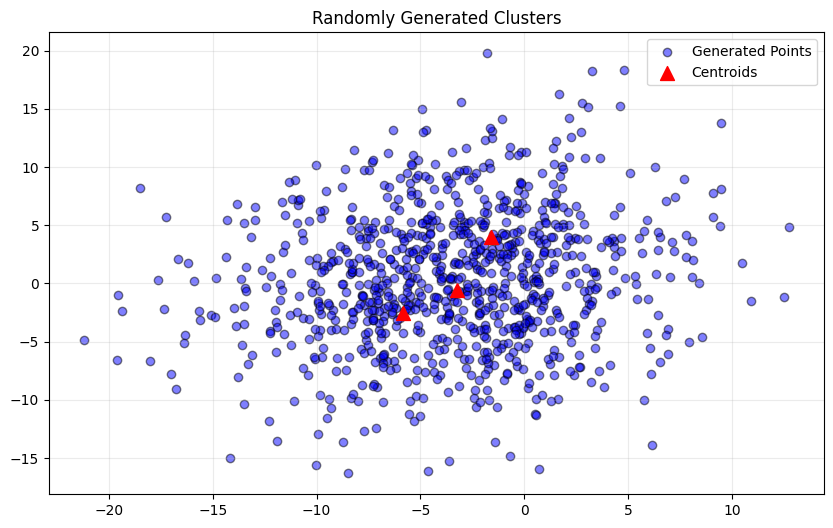

In [417]:
fig, ax = plt.subplots(figsize=(10, 6))
ax.scatter(*zip(*POINTS), color='blue', alpha=0.5, edgecolors='k', label="Generated Points")
ax.scatter(*zip(*CENTROIDS), color='red', marker='^', s=100, label="Centroids")
ax.set_title('Randomly Generated Clusters')
ax.legend()
ax.grid(True, alpha=0.25)

plt.savefig('./data/randomly_generated_clusters.png')

In [418]:
# calculate distance between a point and centroid
# 2 Points: P(x1, y1) and Q(x2, y2)
# Euclidean Distance => sqrt((x2 - x1)^2 + (y2 - y1)^2)
def euclidean_distance(point_1, point_2):
    return math.sqrt((point_2[0] - point_1[0])**2 + (point_2[1] - point_1[1])**2)


# assign each point to the closest centroid based on euclidean_distance
# iterate through all points
def assign_points_to_cluster(points, centroids):
    clusters = [[] for _ in centroids]

    for point in points:
        distances = [euclidean_distance(point, centroid) for centroid in centroids]
        # min(distances) -> smallest distance
        # .index(val) -> returns the index of that min val (closest)
        closest_index = distances.index(min(distances))
        clusters[closest_index].append(point)

    return clusters

In [419]:
CLUSTERS = assign_points_to_cluster(POINTS, CENTROIDS)

In [420]:
# compute new centroids
# update centroids by computing mean of all points in that cluster
def compute_new_centroids(clusters):
    new_centroids = []

    for cluster in clusters:
        if cluster:
            mean_x = sum(p[0] for p in cluster) / len(cluster)
            mean_y = sum(p[1] for p in cluster) / len(cluster)
            new_centroids.append((mean_x, mean_y))
        else:
            new_centroids.append((random.uniform(*COORD_RANGE), random.uniform(*COORD_RANGE)))

    return new_centroids

In [421]:
NEW_CENTROIDS = compute_new_centroids(CLUSTERS)

In [422]:
# Basic K-mean algorithm
# Iterate assign_points_to_cluster and compute_new_centroids
# Stop if centroids don’t change significantly
def k_means(points, k, max_iters=500):
    centroids = random.sample(points, k)

    for _ in range(max_iters):
        clusters = assign_points_to_cluster(points=points, centroids=centroids)
        new_centroids = compute_new_centroids(clusters=clusters)

        centroids = new_centroids

    return centroids, clusters

In [423]:
start_time = time.time()

final_centroids, final_clusters = k_means(points=POINTS, k=NUM_CENTROIDS, max_iters=500)

end_time = time.time()
total_time = end_time- start_time
print(f'K-means time taken: {total_time:.4f}')

K-means time taken: 0.3212


In [424]:
for i in range(len(final_clusters)):
    print(f'Points in cluster_{i+1}: {len(final_clusters[i])}')

Points in cluster_1: 284
Points in cluster_2: 286
Points in cluster_3: 330


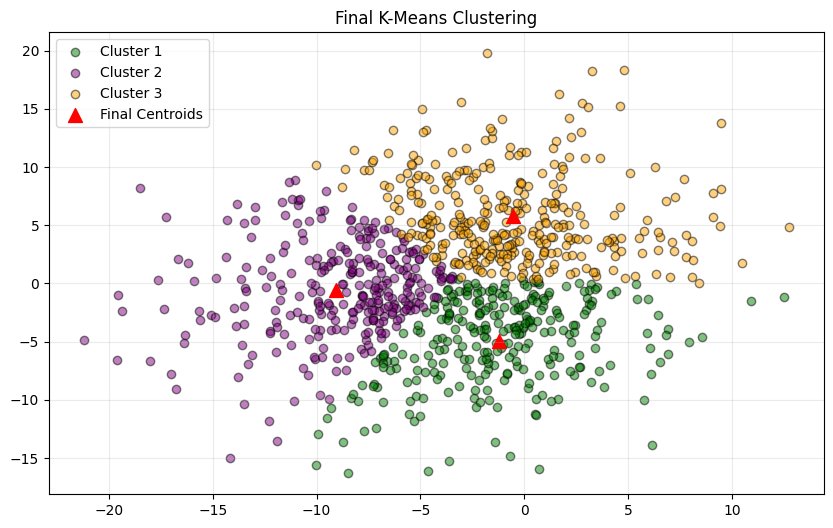

In [425]:
fig, ax = plt.subplots(figsize=(10, 6))
for i, cluster in enumerate(final_clusters):
    ax.scatter(*zip(*cluster), color=COLORS[i], alpha=0.5, edgecolors='k', label=f"Cluster {i+1}")
ax.scatter(*zip(*final_centroids), color='red', marker='^', s=100, label="Final Centroids")
ax.set_title("Final K-Means Clustering")
ax.legend()
ax.grid(True, alpha=0.25)

plt.savefig('./data/kmeans_final_clusters.png')